In [154]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Users/jiayikoh/Downloads/')

# read parquet dataset
df_load = pd.read_parquet('raw-data.parquet', engine='pyarrow')

In [121]:
# take a first glance at the dataset
df_load.head()

,price,buildingSize,landSize,district,city,province,status,isRemoved,submitterId,address,addressInfo,bedRooms,bathRooms,garages,latitude,longitude,createdTime,lastUpdate
0,850000000,100,50,Tambaksari,Surabaya,Jawa Timur,1,0,1fe082d0af115ae88ad360ad1e0db3a0,KAPAS GADING MADYA TENGAH,None,3.0,2,0,,,2021-02-03,2022-02-09
1,1700000000,110,103,None,Tangerang Selatan,Banten,1,0,475d6434d56b72cc488169c93f645b69,dekat bintaro xchange,None,3.0,2,0,None,None,2022-02-22,2022-02-22
2,3500000000,201,113,Matraman,Jakarta Timur,Jakarta,1,0,c4235b4e56b767d1c0e0d7582ce4a7cd,Matraman,None,3.0,4,1,None,None,2021-08-22,2022-02-20
3,38000000000,600,1028,Kemayoran,Jakarta Pusat,Jakarta,1,0,beaca0425ccc1c6441bd67f758970728,,None,5.0,4,4,None,None,2021-01-10,2022-02-07
4,1800000000,150,180,Sidoarjo,Sidoarjo,Jawa Timur,1,0,828ee6ec5419d525d82e7191d8803fb6,KAHURIPAN NIRWANA,None,3.0,2,0,None,None,2021-09-16,2022-02-24


In [122]:
# check data type and missing values
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877725 entries, 0 to 877724
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         877725 non-null  int64  
 1   buildingSize  877725 non-null  int64  
 2   landSize      877725 non-null  int64  
 3   district      554945 non-null  object 
 4   city          869726 non-null  object 
 5   province      877725 non-null  object 
 6   status        877725 non-null  int64  
 7   isRemoved     877725 non-null  int64  
 8   submitterId   877725 non-null  object 
 9   address       877725 non-null  object 
 10  addressInfo   270241 non-null  object 
 11  bedRooms      877077 non-null  float64
 12  bathRooms     877725 non-null  int64  
 13  garages       877725 non-null  int64  
 14  latitude      766794 non-null  object 
 15  longitude     766794 non-null  object 
 16  createdTime   877725 non-null  object 
 17  lastUpdate    877725 non-null  object 
dtypes: f

In [123]:
# identify duplicated values
df_load.duplicated().value_counts()

False    805083
True      72642
dtype: int64

In [155]:
# remove duplicates
df_load.drop_duplicates(inplace=True)

In [156]:
df_load.isna().sum()

price                0
buildingSize         0
landSize             0
district        300855
city              7955
province             0
status               0
isRemoved            0
submitterId          0
address              0
addressInfo     565995
bedRooms           555
bathRooms            0
garages              0
latitude        105835
longitude       105835
createdTime          0
lastUpdate           0
dtype: int64

In [211]:
# create a copy of the original dataset
df = df_load.copy()

### How to deal with the missing value?
- Do an analysis on geographic related columns and to find the correlation

### Fews options
    1) Simplest - fill them with mean/median for numerical and mode for categorical data
    2) Predict the longitude and latitude based on the features available and then proceed to solve the regression problem - due to time constraint will not proceed with this approach
    3) Drop the missings values - only if it consists of at most 5% of the sample size

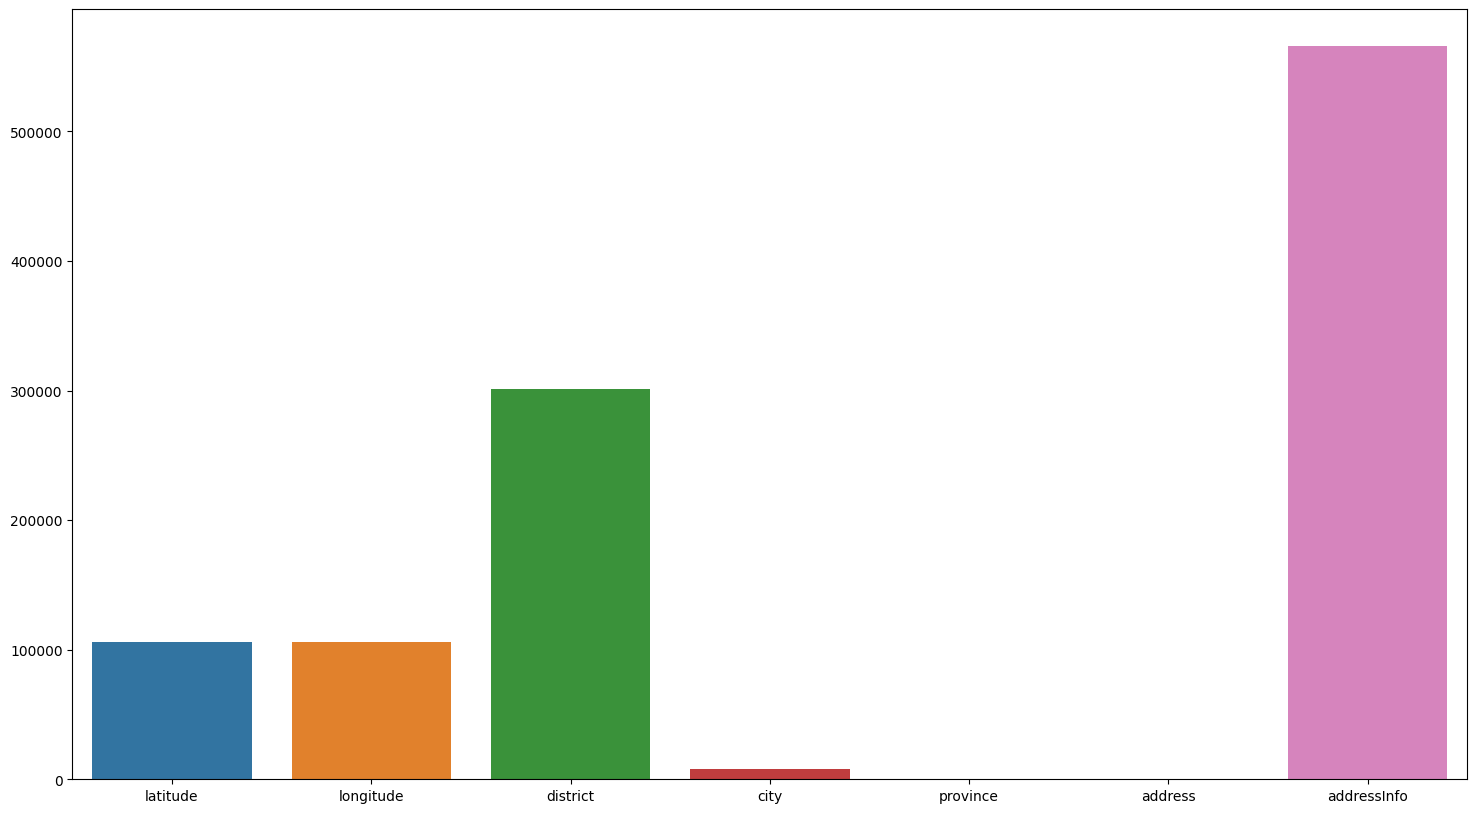

In [16]:
# An analysis on geographic information
geo_col = ['latitude', 'longitude', 'district', 'city', 'province', 'address', 'addressInfo']
geo_df = df[geo_col]

na_count = geo_df.isna().sum(axis=0)
plt.figure(figsize=(18, 10))
plot = sns.barplot(x=geo_col, y=na_count.values)

#### We notice the highest number of NA in addressInfo, it may not be too useful since we have latitude and longitude. We will probably proceed to try dealing with the latitude and longitude NA but not the rest for now 

<AxesSubplot:>

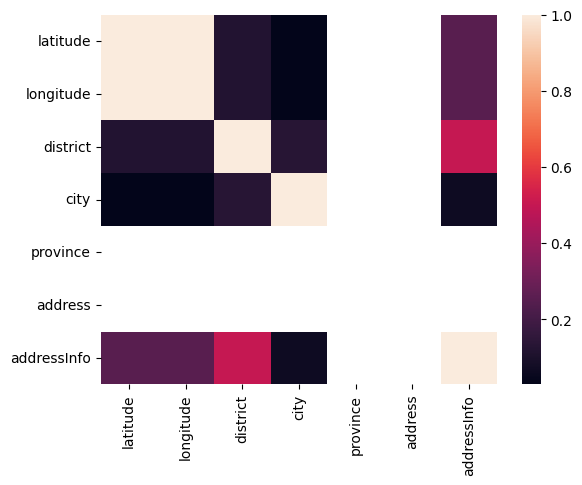

In [17]:
corr_na = geo_df.isna().corr()
sns.heatmap(corr_na, xticklabels = corr_na.columns.values, yticklabels=corr_na.columns.values)

### Check the latitude and longitude of the available data

In [212]:
# drop the missing values for latitude and longitude
df.dropna(subset=['latitude', 'longitude'], inplace=True)

# drop the df with blank space but is not recognized as NA
df = df[df['latitude'] != '']

df[['latitude', 'longitude']] = df[['latitude', 'longitude']].astype(float)

In [213]:
# find the max and min for each latitude and longitude to check where these are located

max_lat = df['latitude'].max()
min_lat = df['latitude'].min()
max_long = df['longitude'].max()
min_long = df['longitude'].min()
print(f"min_lat: {min_lat} | max_lat: {max_lat} | min_long: {min_long} | max_long: {max_long}")

min_lat: -47.772293337449 | max_lat: 77.16141642458 | min_long: -95.67445699999999 | max_long: 140.717


<AxesSubplot:>

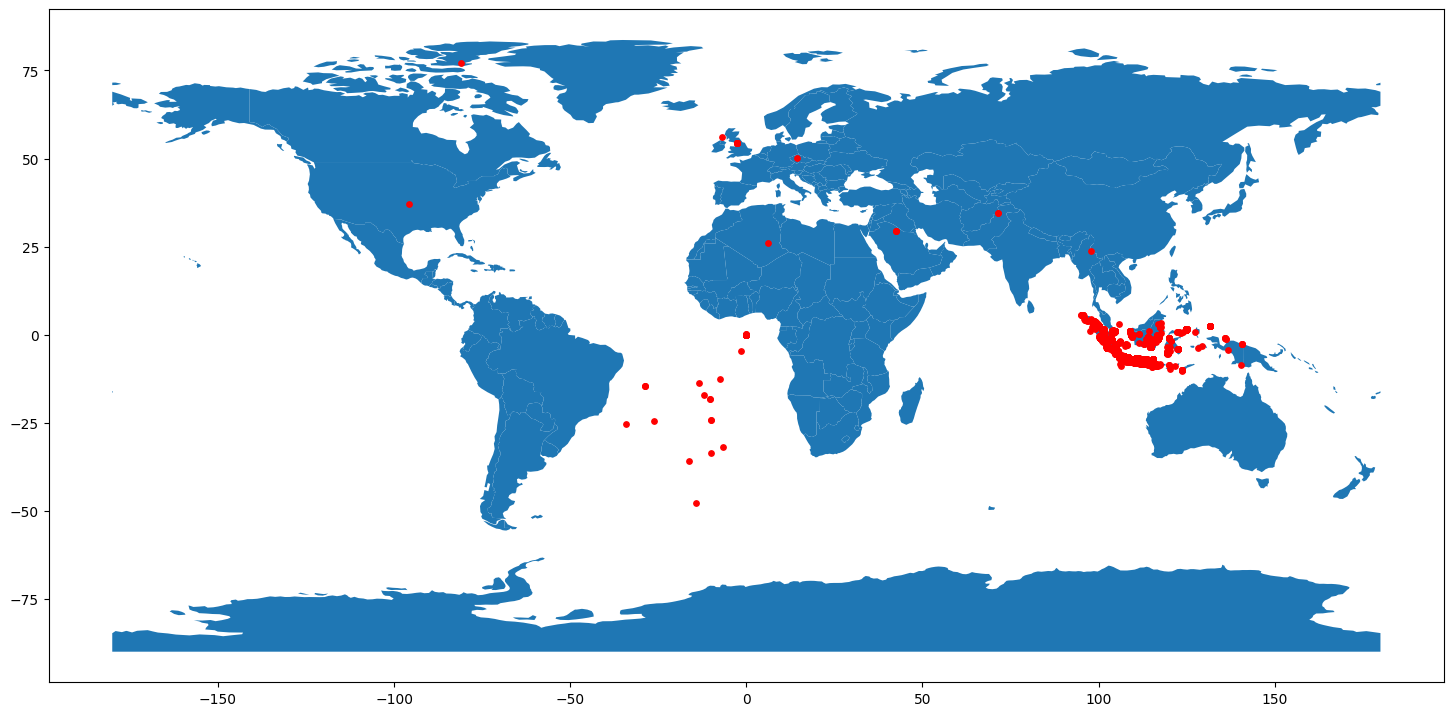

In [24]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

# simple map with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(18, 10)), marker='o', color='red', markersize=15)

#### assuming that the property listing should be mustered at one specific location (Indonesia), remove the red dots by calculating the distance from the centre of Indonesia and to each dot

In [214]:
# import haversine
import haversine as hs

df['centre_latitude'] = -2.600029
df['centre_longitude'] = 118.015776

# calculate the distance between each location and the centre of Indonesia
df['dist_from_centre'] = df.apply(lambda x: hs.haversine((x['latitude'], x['longitude']), (x['centre_latitude'], x['centre_longitude'])), axis=1)

In [161]:
# look into the interquartile range of the dist_from_centre
df['dist_from_centre'].describe()

count    699114.000000
mean       1567.557401
std        2108.375591
min         175.148473
25%        1023.782296
50%        1292.241426
75%        1311.460106
max       15877.826299
Name: dist_from_centre, dtype: float64

<AxesSubplot:xlabel='dist_from_centre', ylabel='Count'>

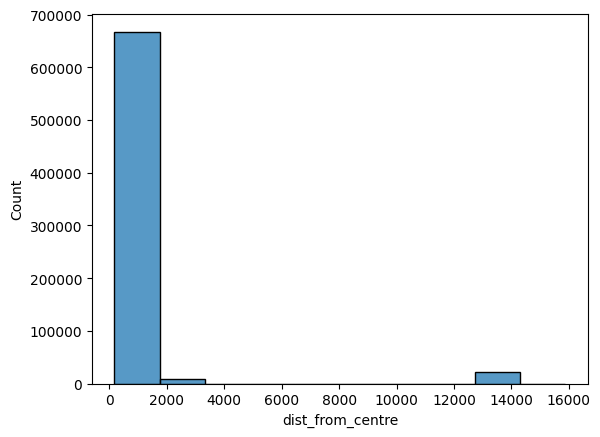

In [131]:
# plot the distribution of the dist_from_centre
sns.histplot(data=df, x='dist_from_centre', bins=10)

In [215]:
# will remove the outlier that is 2000km away from the centre of Indonesia
df_ = df[df['dist_from_centre'] <= 2000]

#### There is about 27k of data being removed (3%) from the dataset due to the invalid geographic information (will think about how to deal with this if time permits)

<AxesSubplot:>

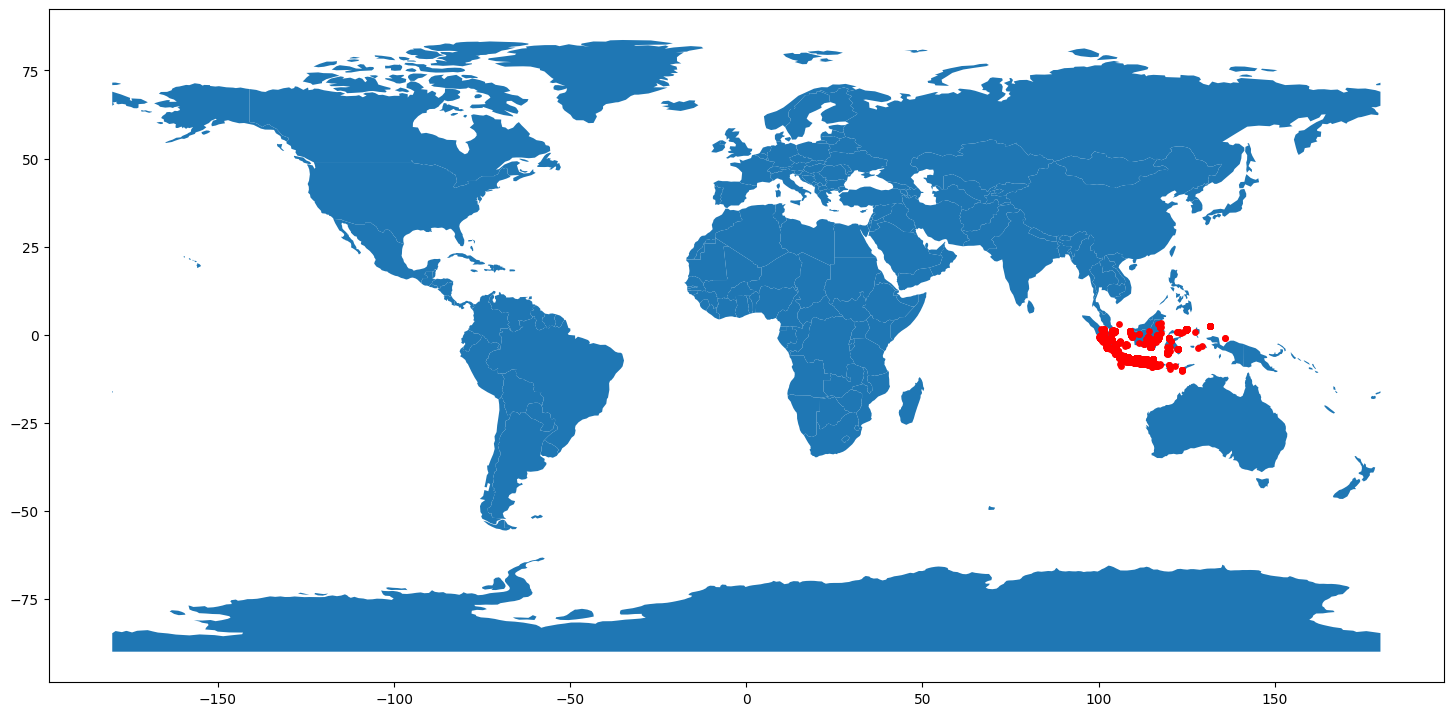

In [31]:
# plot the world chart again
geometry = [Point(xy) for xy in zip(df_['longitude'], df_['latitude'])]
gdf = GeoDataFrame(df_, geometry=geometry)

# simple map with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(18, 10)), marker='o', color='red', markersize=15)

In [216]:
# to adopt the simplest approach to deal with missing values in latitude and longitude - take the mean
na_lat_mean = df_['latitude'].mean()
na_long_mean = df_['longitude'].mean()

# retrieve the original dataset
df = df_load.copy()

# fill missing values and blank values with the mean for latitude and longitude
df = df[(df['latitude'].isna()) | (df['latitude'] == '')]
df['latitude'].fillna(na_lat_mean, inplace=True)
df['latitude'] = np.where(df['latitude'] == '', na_lat_mean, df['latitude'])
df['longitude'].fillna(na_long_mean, inplace=True)
df['longitude'] = np.where(df['longitude'] == '', na_long_mean, df['longitude'])

# concat with df_
df_ = pd.concat([df_, df])

## Exploratory Data Analysis

In [217]:
# check on the distribution for numerical data
df_.describe()

,price,buildingSize,landSize,status,isRemoved,bedRooms,bathRooms,garages,centre_latitude,centre_longitude,dist_from_centre
count,7.801190e+05,7.801190e+05,7.801190e+05,780119.000000,780119.000000,779660.000000,780119.000000,780119.000000,6.741500e+05,6.741500e+05,674150.000000
mean,1.010574e+14,2.916693e+04,1.988411e+04,1.189263,0.073243,3.551492,2.652725,0.464336,-2.600029e+00,1.180158e+02,1182.759114
std,2.953356e+16,9.851872e+06,7.454334e+06,0.636460,0.260535,3.597782,2.897175,1.098139,4.440895e-15,1.421087e-13,216.331160
min,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000,0.000000,0.000000,-1.000000,0.000000,-2.600029e+00,1.180158e+02,175.148473
25%,7.250000e+08,6.500000e+01,8.000000e+01,1.000000,0.000000,2.000000,1.000000,0.000000,-2.600029e+00,1.180158e+02,1020.558830
50%,1.700000e+09,1.260000e+02,1.200000e+02,1.000000,0.000000,3.000000,2.000000,0.000000,-2.600029e+00,1.180158e+02,1289.986622
75%,3.500000e+09,2.400000e+02,2.120000e+02,1.000000,0.000000,4.000000,3.000000,1.000000,-2.600029e+00,1.180158e+02,1310.328812
max,9.223372e+18,4.294967e+09,4.294967e+09,5.000000,1.000000,550.000000,127.000000,215.000000,-2.600029e+00,1.180158e+02,1991.508807


### At first glance, there seem to be outliers in price, buildingSize and landSize that have skewed the distribution of the data, we may have to look into it

In [137]:
# look into the dataset with the extreme values
df_.sort_values('price', ascending=False).head(10)

## these extreme values are duplicated in the latitude and longitude, the price, buildingSize and landSize are unreasonable too

,price,buildingSize,landSize,district,city,province,status,isRemoved,submitterId,address,...,bedRooms,bathRooms,garages,latitude,longitude,createdTime,lastUpdate,centre_latitude,centre_longitude,dist_from_centre
512732,9223372036854775807,1,1,Pakis,Malang,Jawa Timur,5,0,b287542593cdffe4323162ee078ec42f,upek upek asrikaton,...,7.0,7,0,-7.944561,112.693611,2022-03-08,2022-03-08,-2.600029,118.015776,836.769599
87695,9223372036854775807,4294967295,10000000,Pakis,Malang,Jawa Timur,5,0,1d8db89226a7115ca658fdbd52296e9c,upek-upek asikatun,...,3.0,4,0,-7.944561,112.693611,2022-02-17,2022-02-17,-2.600029,118.015776,836.769599
471986,9223372036854775807,9,1333,Pakis,Malang,Jawa Timur,5,0,b287542593cdffe4323162ee078ec42f,upek upek asrikaton,...,7.0,6,0,-7.944561,112.693611,2022-03-07,2022-03-07,-2.600029,118.015776,836.769599
581210,9223372036854775807,4,9,Pakis,Malang,Jawa Timur,5,0,ea8eddb5ddb78ddb1068c507c570f204,upek-upek asriikaton,...,1.0,1,0,-7.944561,112.693611,2022-03-08,2022-03-08,-2.600029,118.015776,836.769599
512707,9223372036854775807,7,6,Pakis,Malang,Jawa Timur,5,0,b287542593cdffe4323162ee078ec42f,upek upek asrikaton,...,3.0,5,0,-7.944561,112.693611,2022-03-07,2022-03-07,-2.600029,118.015776,836.769599
801676,9223372036854775807,80,87,Pakis,Malang,Jawa Timur,5,0,ea8eddb5ddb78ddb1068c507c570f204,upek-upek asriikaton,...,9.0,6,0,-7.944561,112.693611,2022-03-08,2022-03-08,-2.600029,118.015776,836.769599
471960,9223372036854775807,733333322,12222222,Pakis,Malang,Jawa Timur,5,0,b287542593cdffe4323162ee078ec42f,upek upek asrikaton,...,10.0,3,0,-7.944561,112.693611,2022-03-07,2022-03-07,-2.600029,118.015776,836.769599
372466,9000000000000000000,3555556677,4294967295,Pakis,Malang,Jawa Timur,5,0,057813328d63c35fa86aaa3d19c2534c,upek upek asrikaton,...,10.0,9,0,-7.944561,112.693611,2022-02-03,2022-02-03,-2.600029,118.015776,836.769599
472040,1000000000000000000,10000,10000,Pakis,Malang,Jawa Timur,5,0,1d8db89226a7115ca658fdbd52296e9c,upek-upek asrikatun,...,6.0,5,0,-7.944561,112.693611,2022-03-08,2022-03-08,-2.600029,118.015776,836.769599
764586,1000000000000000000,10000000,10000000,Pakis,Malang,Jawa Timur,5,0,1d8db89226a7115ca658fdbd52296e9c,upek-upek asikatun,...,4.0,2,0,-7.944561,112.693611,2022-03-07,2022-03-07,-2.600029,118.015776,836.769599


In [170]:
# filter only price > 3rd quartile
import wquantiles

df_[df_['price'] > df_['price'].quantile(0.75)]

,price,buildingSize,landSize,district,city,province,status,isRemoved,submitterId,address,...,bedRooms,bathRooms,garages,latitude,longitude,createdTime,lastUpdate,centre_latitude,centre_longitude,dist_from_centre
4115,4000000000,150,208,None,Bekasi,Jawa Barat,1,0,3e4f8de8121f6ed78386b7cfafab56e6,Cluster vernonia,...,4.0,4,0,-6.23333,107.0,2022-02-05,2022-02-19,-2.600029,118.015776,1286.143886
4120,4000000000,150,208,None,Bekasi,Jawa Barat,1,0,ed06066bcf826de7055bed03e6dc0689,Summarecon Bekasi Cluster Vernonia Bekasi,...,3.0,3,1,-6.23333,107.0,2022-02-14,2022-02-14,-2.600029,118.015776,1286.143886
4121,3650000000,205,180,None,Bekasi,Jawa Barat,1,0,6bed9cdfe59baec0859b553d2ab077ee,Cluster Maple Summarecon Bekasi,...,3.0,3,0,-6.23333,107.0,2021-12-08,2022-02-22,-2.600029,118.015776,1286.143886
4129,4000000000,150,144,Bekasi Barat,Bekasi,Jawa Barat,1,0,f4dc336ec6c70b224e0dc4e892076cfb,Cluster Vernonia Summarecon Bekasi,...,3.0,3,0,-6.23333,107.0,2022-02-04,2022-02-04,-2.600029,118.015776,1286.143886
4140,11000000000,870,500,Bekasi Barat,Bekasi,Jawa Barat,1,0,6bed9cdfe59baec0859b553d2ab077ee,Perumahan Jakapermai,...,7.0,7,3,-6.23333,107.0,2021-12-19,2022-02-22,-2.600029,118.015776,1286.143886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845477,7850000000,550,375,None,Surabaya,Jawa Timur,1,0,ef86de8c5adfb9c9616c0c8297820cc6,DHARMAHUSADA INDAH BARAT,...,4.0,4,0,-6.614923,108.356491,2021-10-12,2022-03-11,NaN,NaN,NaN
845481,200000000000,1676,2915,Menteng,Jakarta Pusat,Jakarta,1,0,be5f5fff26cf85432aedf098bb8ad346,Menteng,...,5.0,4,10,-6.614923,108.356491,2021-04-13,2022-03-07,NaN,NaN,NaN
845482,10000000000,450,390,None,Jakarta Selatan,Jakarta,1,0,7fce989d04c44434e43f2998a46251d9,Bintaro IND,...,7.0,7,4,-6.614923,108.356491,2021-01-06,2022-03-12,NaN,NaN,NaN
845485,5300000000,240,266,Ubud,Gianyar,Bali,1,0,bc3fbc6b36271186785f38461935e01b,TIRTA TAWAR,...,3.0,3,0,-6.614923,108.356491,2022-03-10,2022-03-10,NaN,NaN,NaN


In [218]:
# Did a check in 99.co Indonesia website and found out that the maximum price is 50,000,000,000, will remove those that are above this threshold

df_ = df_[(df_['price'] <= 50000000000) & (df_['price'] >= 100000)]

### removing those price that are beyond the maximum and minimum price saw in 99.co Indonesia website (account for less than 1% of the sample size)

### notice that the buildingSize & landSize may have extreme values as well, will create an indicator price/buildingSize and price/landSize and remove those that are greather than 2 standard deviations from the mean

In [219]:
df_['price/bsize'] = df_['price'] / df_['buildingSize']
df_['price/lsize'] = df_['price'] / df_['landSize']

# remove infinity because of division by 0
df_ = df_[(~df_['price/bsize'].isin([np.inf, -np.inf])) & (~df_['price/lsize'].isin([np.inf, -np.inf]))]

# remove data from 2 std away
df_ = df_[(df_['price/bsize'] <= (df_['price/bsize'].mean() + 2*df_['price/bsize'].std())) & (df_['price/lsize'] <= (df_['price/lsize'].mean() + 2*df_['price/lsize'].std()))]

In [220]:
df_.describe()

,price,buildingSize,landSize,status,isRemoved,bedRooms,bathRooms,garages,centre_latitude,centre_longitude,dist_from_centre,price/bsize,price/lsize
count,7.695090e+05,7.695090e+05,7.695090e+05,769509.000000,769509.000000,769509.000000,769509.000000,769509.000000,6.665330e+05,6.665330e+05,666533.000000,7.695090e+05,7.695090e+05
mean,3.332980e+09,2.597948e+03,1.275906e+04,1.191438,0.073495,3.523939,2.630358,0.450860,-2.600029e+00,1.180158e+02,1182.608484,1.539781e+07,1.543521e+07
std,5.284146e+09,2.108943e+06,5.568957e+06,0.630734,0.260947,3.188164,2.663268,0.986878,3.996806e-15,1.421087e-13,216.407790,1.258824e+07,1.275961e+07
min,1.000000e+05,1.000000e+00,1.000000e+00,-5.000000,0.000000,0.000000,0.000000,0.000000,-2.600029e+00,1.180158e+02,175.148473,1.000000e+00,1.000000e+00
25%,7.140001e+08,6.500000e+01,8.000000e+01,1.000000,0.000000,2.000000,1.000000,0.000000,-2.600029e+00,1.180158e+02,1020.242648,9.375000e+06,7.504243e+06
50%,1.700000e+09,1.270000e+02,1.200000e+02,1.000000,0.000000,3.000000,2.000000,0.000000,-2.600029e+00,1.180158e+02,1289.647843,1.304348e+07,1.250001e+07
75%,3.500000e+09,2.400000e+02,2.100000e+02,1.000000,0.000000,4.000000,3.000000,1.000000,-2.600029e+00,1.180158e+02,1310.328812,1.805556e+07,2.000000e+07
max,5.000000e+10,1.850000e+09,4.294967e+09,5.000000,1.000000,375.000000,127.000000,116.000000,-2.600029e+00,1.180158e+02,1991.508807,6.400000e+08,5.222222e+08


In [221]:
# find the mean and trim
from scipy import stats

print(f"the mean of price: {df_['price'].mean()/1000000}")
print(f"the trim mean of price: {stats.trim_mean(df_['price'], 0.1)/1000000}")

the mean of price: 3332.980260544728
the trim mean of price: 2167.513938794457


### Assumptions to be made:
    1) Status - due to time constraint, I do not have the information for each status description. Will still include in the prediction to check the usefulness
    2) isRemoved - due to time constraint, I will assume that this means upon the lastUpdate, whether this listing is still valid
    3) listing duration - will create a new feature lastUpdate - createdTime

In [222]:
# create a new column for listing_duration
df_[['createdTime', 'lastUpdate']] = df_[['createdTime', 'lastUpdate']].apply(pd.to_datetime)
df_['listing_duration'] = (df_['lastUpdate'] - df_['createdTime']).dt.days/365

In [223]:
# create a correlation heatmap
corr_heatmap = df_.corr()
corr_heatmap['price'].sort_values(ascending=False)

price               1.000000
price/bsize         0.578290
price/lsize         0.550873
garages             0.336890
bathRooms           0.332105
bedRooms            0.280165
dist_from_centre    0.039604
listing_duration    0.020894
landSize            0.000487
buildingSize       -0.000248
isRemoved          -0.030475
status             -0.053886
centre_latitude          NaN
centre_longitude         NaN
Name: price, dtype: float64

/var/folders/x4/ds_2jp8s5f185jbkg856cn680000gn/T/ipykernel_21729/2782360092.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr_heatmap, dtype=np.bool))


Text(0.5, 1.0, 'Correlation Heatmap')

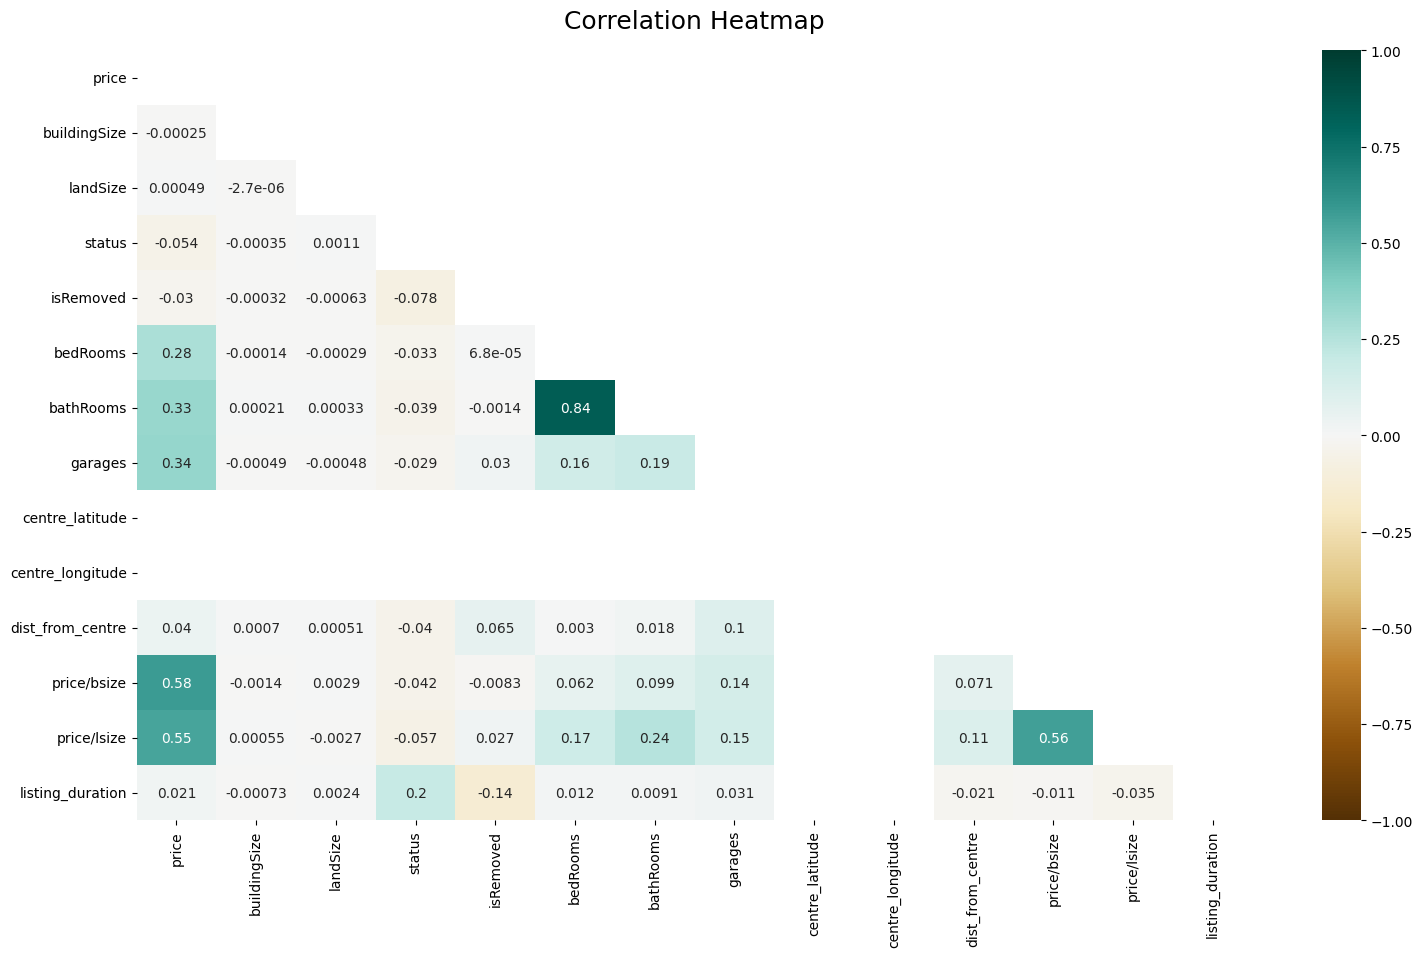

In [224]:
# plot a correlation heatmap

plt.figure(figsize=(18, 10))

mask = np.triu(np.ones_like(corr_heatmap, dtype=np.bool))

heatmap = sns.heatmap(corr_heatmap, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

#### price, buildingSize, landSize may require data scaling 
    1) simple division (by 10^(x)) may not work well due to the dispersion in data
    2) will do a logarithm scaling to the numerical data 

In [225]:
# 2nd method: log data
df_['log_price'] = np.log(df_['price'])
df_['log_buildingSize'] = np.log(df_['buildingSize'])
df_['log_landSize'] = np.log(df_['landSize'])

In [226]:
df_[['log_price', 'log_buildingSize', 'log_landSize']].describe()

,log_price,log_buildingSize,log_landSize
count,769509.000000,769509.000000,769509.000000
mean,21.236250,4.860677,4.939064
std,1.161876,0.858282,0.760276
min,11.512925,0.000000,0.000000
25%,20.386394,4.174387,4.382027
50%,21.253894,4.844187,4.787492
75%,21.976029,5.480639,5.347108
max,24.635289,21.338451,22.180710


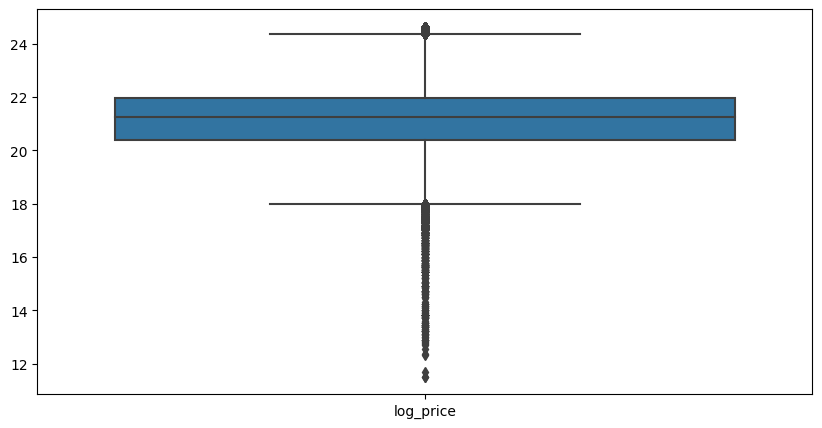

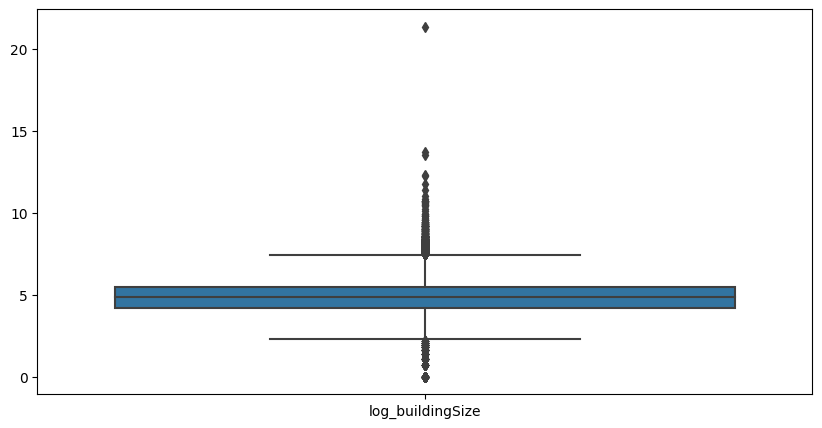

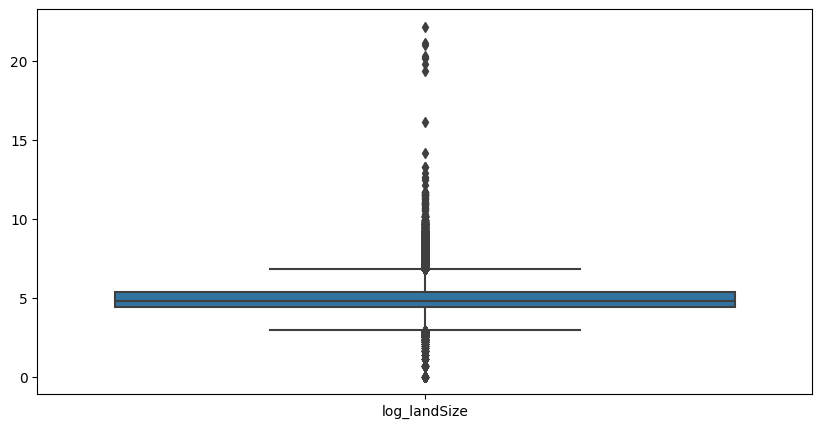

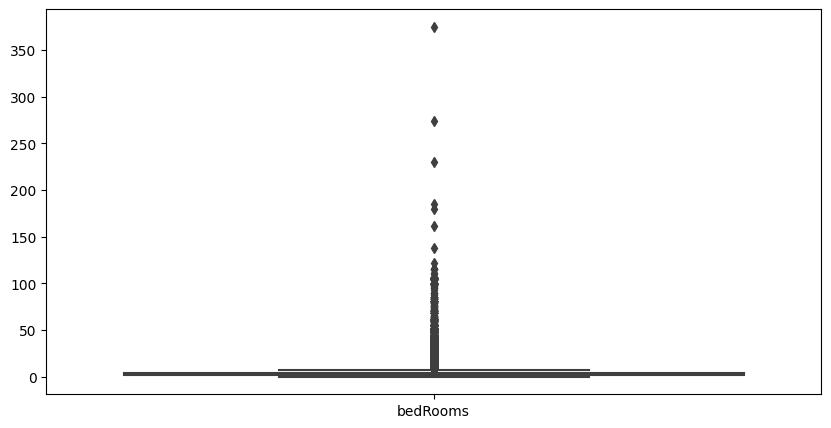

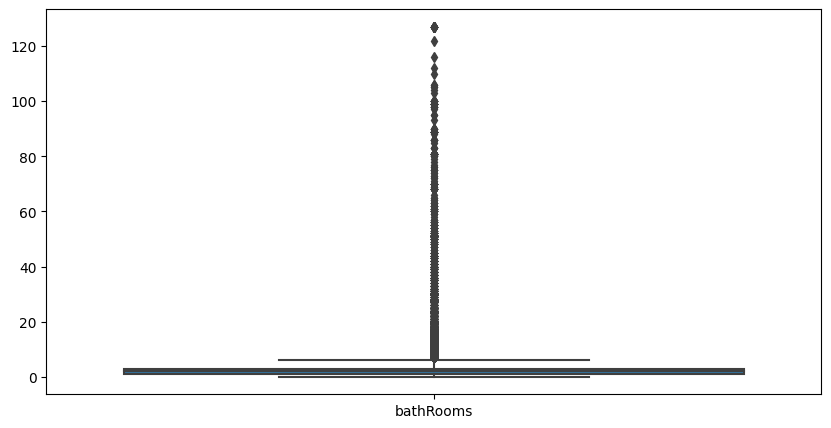

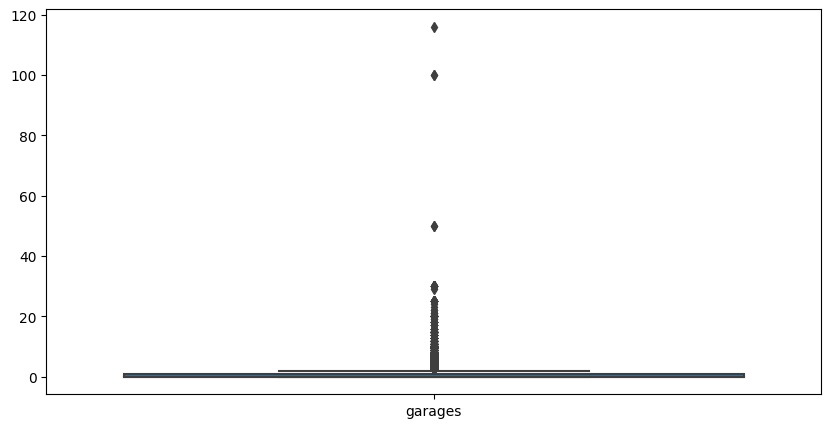

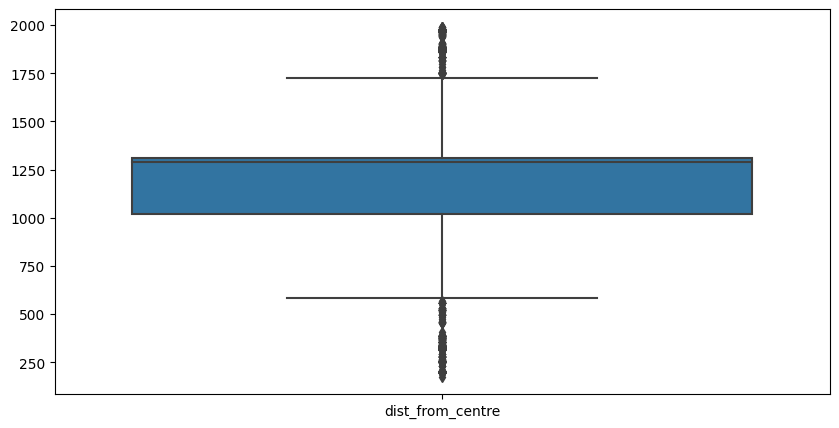

In [227]:
# boxplot of numerical data to spot any patterns
num_col = ['log_price', 'log_buildingSize', 'log_landSize', 'bedRooms', 'bathRooms', 'garages', 'dist_from_centre']
for i, j in enumerate(df_[num_col].columns):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_[[j]])

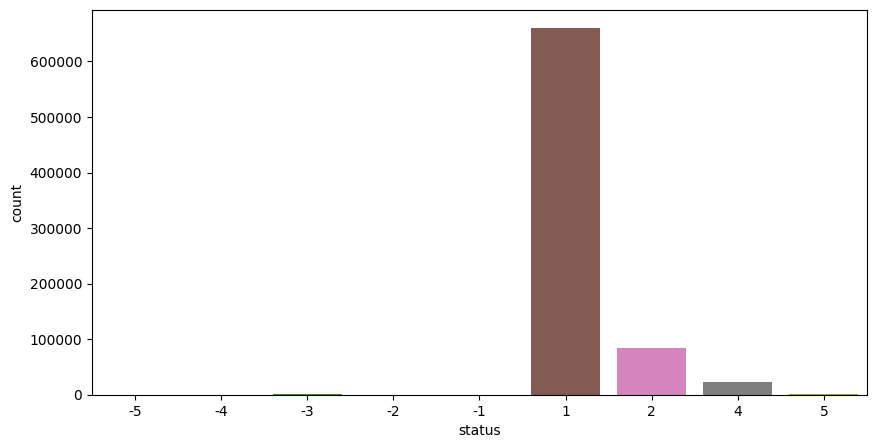

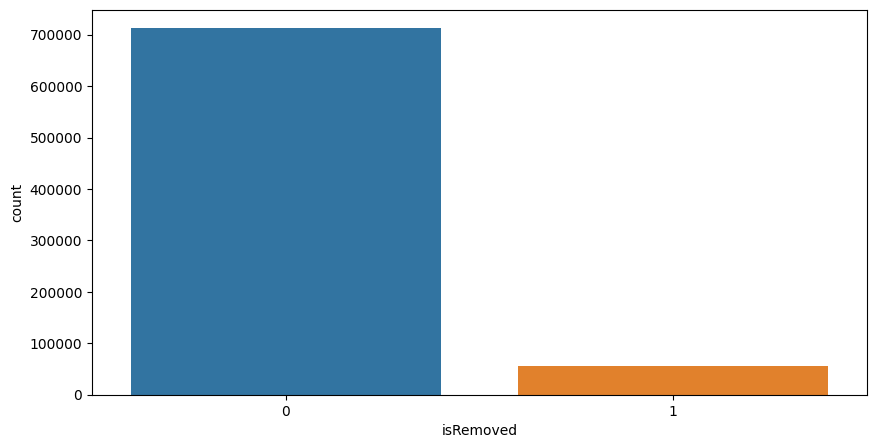

In [228]:
cat_col = ['status', 'isRemoved']
for i, j in enumerate(df_[cat_col].columns):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df_, x=j)

## based on the EDA above
    1) caught my attention when I notice there is property with > 10 bedrooms, 10 bathrooms, 10 garages
    - after checking with 99.co Indonesia website, notice that it may be a hotel/commercial
    - will be good if I am able to capture what type of property it is in my price prediction (I will still proceed with the dataset)

## Deciding on the features and train the model
- exclude categorical variables like ID, date, address
- exclude certain numerical variables that are not making sense to the model price/bsize, price/lsize

In [229]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 769509 entries, 4111 to 869880
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             769509 non-null  int64         
 1   buildingSize      769509 non-null  int64         
 2   landSize          769509 non-null  int64         
 3   district          478424 non-null  object        
 4   city              763672 non-null  object        
 5   province          769509 non-null  object        
 6   status            769509 non-null  int64         
 7   isRemoved         769509 non-null  int64         
 8   submitterId       769509 non-null  object        
 9   address           769509 non-null  object        
 10  addressInfo       220445 non-null  object        
 11  bedRooms          769509 non-null  float64       
 12  bathRooms         769509 non-null  int64         
 13  garages           769509 non-null  int64         
 14  l

In [232]:
# convert latitude and longitude to float
df_[['latitude', 'longitude']] = df_[['latitude', 'longitude']].astype(float) 
attributes = ['log_price', 'log_buildingSize', 'log_landSize', 'status', 'isRemoved', 'bedRooms', 'bathRooms', 'garages', 'latitude', 'longitude', 'listing_duration']

df_for_model = df_[attributes]

In [235]:
# split X and y
X = df_for_model.drop(columns='log_price')
y = df_for_model['log_price']


# split into train and test size
np.random.seed(42)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [236]:
# base model to use a linear regression as benchmark
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

LinearRegression()

In [238]:
# get the coefficient of each variable
coeff_parameter = pd.DataFrame(reg_model.coef_, X.columns, columns=['Coefficient'])

In [239]:
coeff_parameter

,Coefficient
log_buildingSize,0.948655
log_landSize,0.313846
status,-0.026190
isRemoved,0.023875
bedRooms,-0.026635
bathRooms,0.029536
garages,0.019088
latitude,-0.042937
longitude,-0.035243
listing_duration,-0.074107


In [240]:
reg_model.intercept_

18.669427487308763

#### The sign of each coefficient indicates the direction of the relationship between the variable and the log_price

<AxesSubplot:>

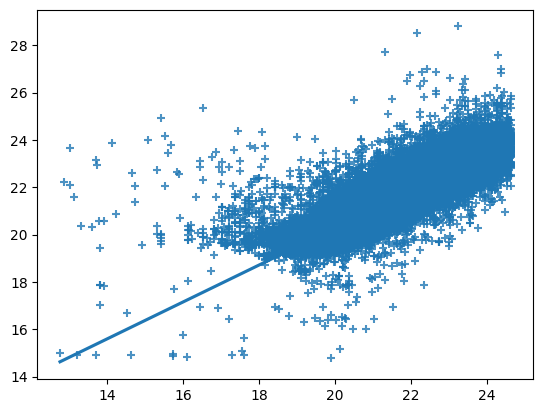

In [249]:
# predict on the test set
reg_pred = reg_model.predict(X_test)

# plot the actual value against prediction
sns.regplot(x=np.array(y_test), y=reg_pred, marker='+')

#### It is pretty difficult to see whether our model is doing well in predicting, will have to check the R-squared value

In [252]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)

ls = sm.OLS(y_train, X_train_sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 2.199e+05
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        02:28:03   Log-Likelihood:            -4.9787e+05
No. Observations:              615607   AIC:                         9.958e+05
Df Residuals:                  615596   BIC:                         9.959e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               18.6694      0.036  

In [256]:
# evaluating regression models metrics
from sklearn import metrics

# print results for MAE
print(f"MAE: {metrics.mean_absolute_error(y_test, reg_pred)}")

# print results of MSE
print(f"MSE: {metrics.mean_squared_error(y_test, reg_pred)}")

# print results of RMSE
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, reg_pred))}")

MAE: 0.3933863462416099
MSE: 0.29514090251716596
RMSE: 0.5432687203559265


#### RMSE score is not as good as expected, will like to see if we can keep it below 0.2

#### We are able to obtain Adjusted R-squared of around 78% which is pretty good, however, I would like to attempt fitting using XGBoost and see whether it improves the R-squared value

In [261]:
## trying another model using XGBoost
import xgboost as xg

xgb_model = xg.XGBRegressor(eval_metric='rmse')

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [262]:
# predict on the test set
xgb_pred = xgb_model.predict(X_test)

In [263]:
# evaluating regression models metrics

# print R-squared value
print(f"R-squared: {metrics.r2_score(y_test, xgb_pred)}")

# print results for MAE
print(f"MAE: {metrics.mean_absolute_error(y_test, xgb_pred)}")

# print results of MSE
print(f"MSE: {metrics.mean_squared_error(y_test, xgb_pred)}")

# print results of RMSE
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, xgb_pred))}")

R-squared: 0.8891083014436253
MAE: 0.2523102914133777
MSE: 0.14993964881031743
RMSE: 0.3872204137314011


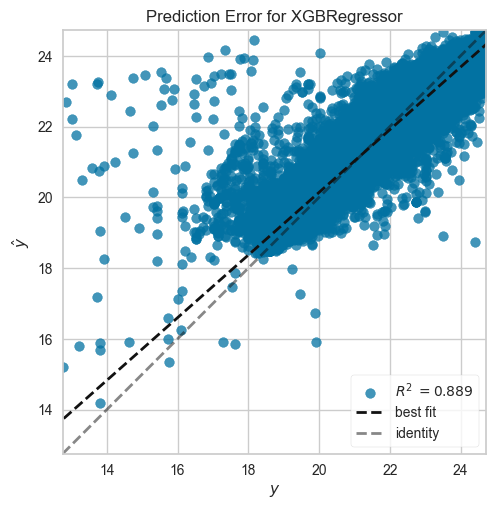

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric='rmse', gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.300000012, max_bin=256,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=6, max_leaves=0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=0,
                                       num_parallel_tree=1, predictor='auto',
                                       random_state=0, reg_alpha=0,
                                       reg_lambda=1, ...))

In [266]:
# plot a prediction error plot & residuals plot
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error


prediction_error(xgb_model, X_train, y_train, X_test, y_test)

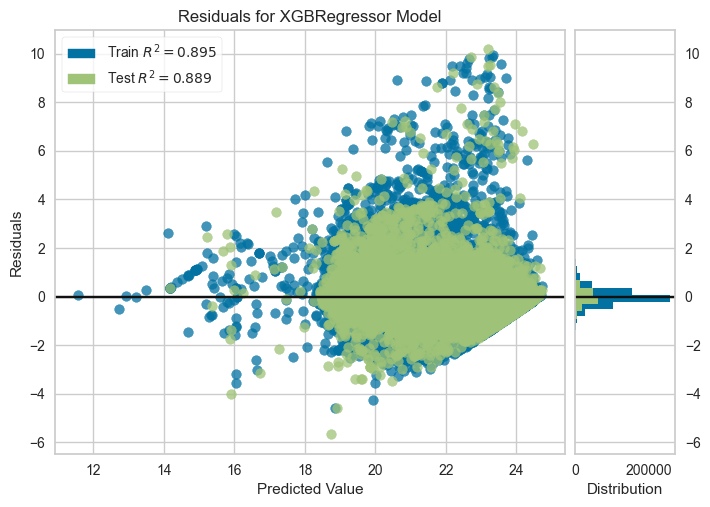

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'XGBRegressor' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'XGBRegressor' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'XGBRegressor' have attribute 'line_color'

In [267]:
residuals_plot(xgb_model, X_train, y_train, X_test, y_test)

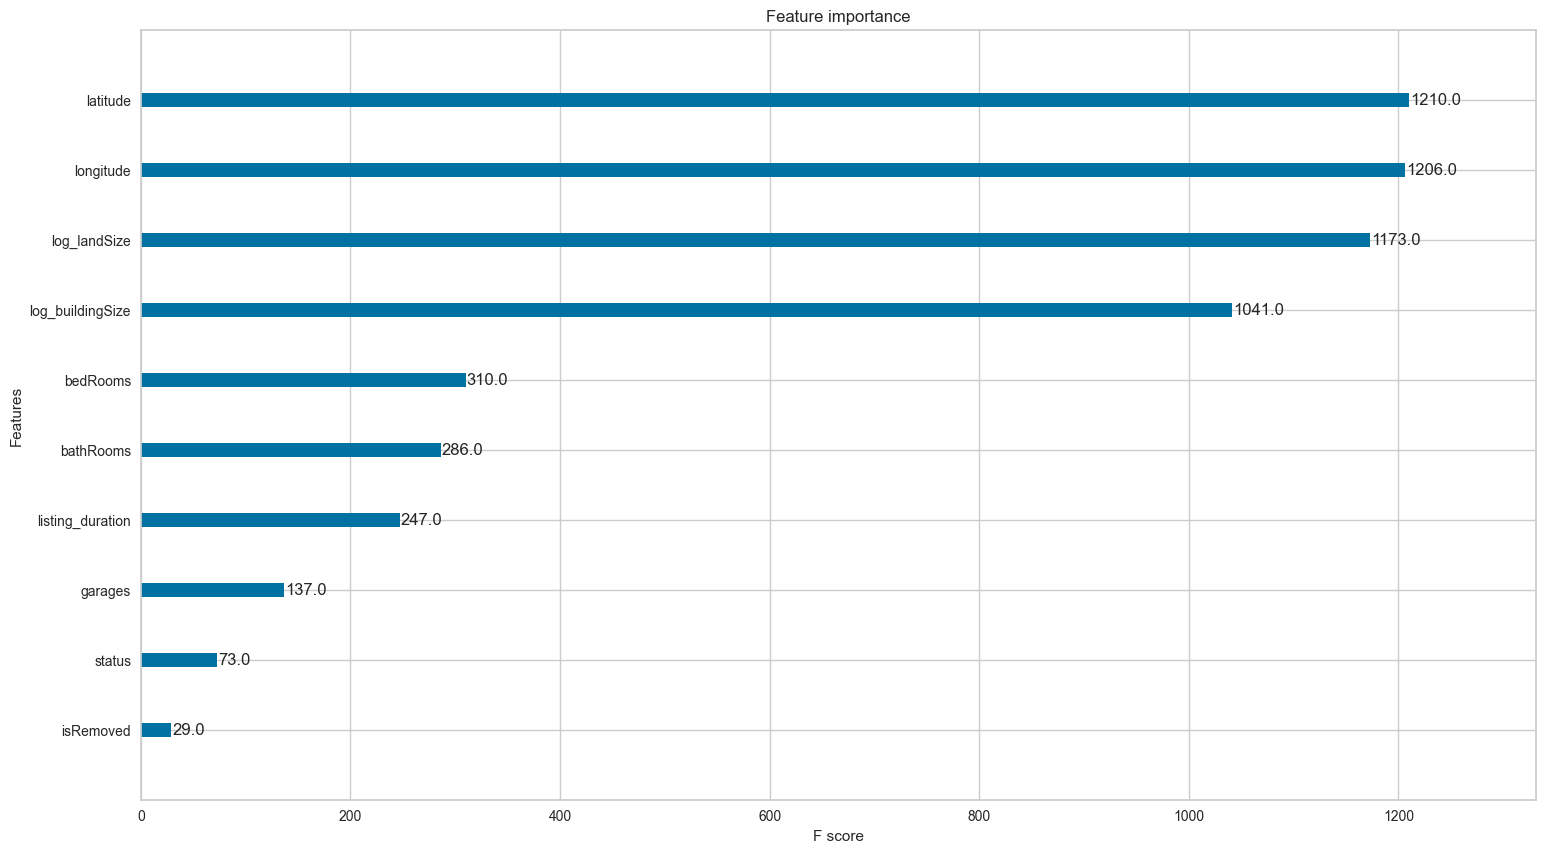

In [269]:
# A quick look at the feature importance provided by XGBoost package
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(18, 10))
plot_importance(xgb_model, ax=ax)
plt.show()

### Conclusion: XGBoost does perform better in terms of R-Squared and RMSE, we could further improve the performance by adjusting the hyperparameters and by using other models

### In overall, we did a good job in predicting the property price with our models

### There are still space for improvement
    1) to look at all the available internal data (i.e. property type)
    2) to look at external data (i.e. bond yield curve/CPI as economic indicator)